In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os
def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)



# Example - Stochastic Exponetial Growth

In this activity we will be looking at Stochastic exponential growth, also called geometric Brownian motion. This is a model for a quantity that grows or decays exponentially, but with random fluctuations. This is a common model for many real-world processes, such as the growth of populations, the spread of diseases, and the movement of stock prices. The stochastic process is given by 

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

We will be demonstration stochastic exponential growth by looking at cancer cell populations. The data is from the paper by [Johnson et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3000399)

Let me extract this data for you.

In [ ]:
pip install optax

In [17]:
import jax
from jax import grad, jit, vmap, lax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as jss
import optax
import pandas as pd

jax.config.update("jax_enable_x64", True)
colors = sns.color_palette()
key = jr.PRNGKey(0)

# Reload the CSV with no header
url = 'https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/cancer_growth.csv'
download(url)
data = pd.read_csv('cancer_growth.csv', header=None)

# Extract metadata
column_labels = data.iloc[0].values  # First row: Column names with prefixes
seed_info = data.iloc[1].values      # Second row: Seeding information

# Extract actual data
data_values = data.iloc[2:].reset_index(drop=True).astype(float)

# Initialize dictionaries for storing the time and cell count arrays
time_dict = {}
count_dict = {}

# Iterate over unique seed values
for seed in set(seed_info):
    # Get columns belonging to the current seed
    seed_columns = [i for i, seed_val in enumerate(seed_info) if seed_val == seed]
    seed_labels = column_labels[seed_columns]
    
    # Identify time and count columns
    time_cols = [i for i, label in zip(seed_columns, seed_labels) if "time" in label]
    count_cols = [i for i, label in zip(seed_columns, seed_labels) if "time" not in label]
    
    # Assign JAX arrays for time and counts based on seed
    if time_cols:
        time_dict[seed] = jnp.array(data_values.iloc[:, time_cols].values)
    if count_cols:
        count_dict[seed] = jnp.array(data_values.iloc[:, count_cols].values)

# Extract the desired arrays
t2 = time_dict["n=2"][~jnp.isnan(time_dict["n=2"])]
t4 = time_dict["n=5"][~jnp.isnan(time_dict["n=5"])]
t10 = time_dict["n=12"][~jnp.isnan(time_dict["n=12"])]
P2 = count_dict["n=2"][:len(t2)]
P4 = count_dict["n=5"][:len(t4)]
P10 = count_dict["n=12"][:len(t10)]

So what we have here are cancer cell counts observed over time. The growth rate is exponential, but with stochastic effect due to the randomness in cell division and death. What we have is three different datasets with three different cell seeding numbers. Many experiments were done for each seeding number, and the population size was recorded over time. Lets take a look.

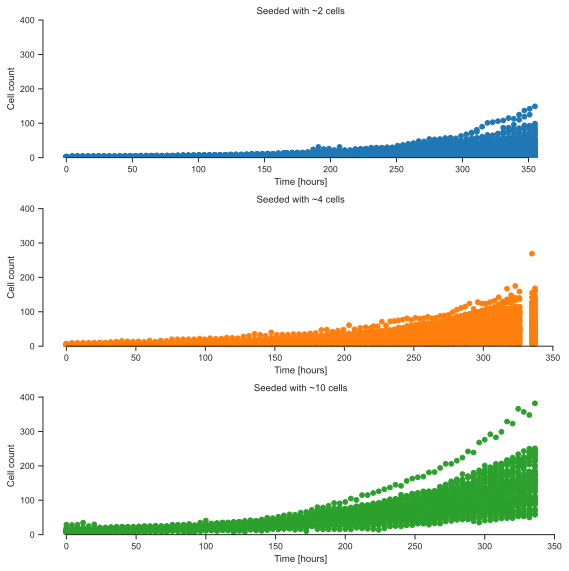

In [18]:
# Plot the three different seeding conditions
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(t2, P2, 'o', color=colors[0])
axs[0].set_title("Seeded with ~2 cells")
axs[1].plot(t4, P4, 'o', color=colors[1])
axs[1].set_title("Seeded with ~4 cells")
axs[2].plot(t10, P10, 'o', color=colors[2])
axs[2].set_title("Seeded with ~10 cells")
axs[0].set_ylabel("Cell count")
axs[1].set_ylabel("Cell count")
axs[2].set_ylabel("Cell count")
axs[0].set_xlabel("Time [hours]")
axs[1].set_xlabel("Time [hours]")
axs[2].set_xlabel("Time [hours]")
# Set axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 400)
plt.tight_layout()
sns.despine(trim=True)
plt.show()

We will model this using a stochastic differential equation (SDE) with different growth rates for each dataset. We will use the Euler-Maruyama method to simulate the SDE.
We can write down a simple stochastic exponential growth model as follows:

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

where $X_t$ is the population size at time $t$, $\mu$ is the deterministic growth rate, $\sigma$ is the volatility, and $W_t$ is a Wiener process, which we learned about in the previous notebook.

We can simulate this model using the Euler-Maruyama method, which is a numerical method for solving stochastic differential equations. The Euler-Maruyama method is an extension of the Euler method for ordinary differential equations.

The Euler-Maruyama method is given by:

$$
X_{t+\Delta t} = X_t + \mu X_t \Delta t + \sigma X_t \sqrt{\Delta t} Z
$$

where $Z$ is a sample from a standard normal distribution, which is what the Wiener process reduces to in the Euler-Maruyama discretization. 

So you can think about this as a state that which increments according to a normal distribution.

$$
\Delta X_i = X_{t_{i+1}} - X_{t_i} \sim N(\mu X_{t_i} \Delta t, \sigma^2 X_{t_i} \Delta t)
$$

Let me demonstrate this for you with a generic example.

In [19]:
# Define the Euler-Maruyama method
def euler_maruyama_step(carry, dt):
    """Perform a single step of the Euler-Maruyama method."""
    # Unpack the state
    key, mu, std, x0 = carry

    # Split the random key, we want iid samples each step
    key, subkey = jr.split(key)

    # Compute the drift term
    drift = mu*x0*dt

    # Compute the diffusion term
    diffusion = std*x0*jnp.sqrt(dt)*jr.normal(subkey)

    x1 = x0+ drift + diffusion

    return (key, mu, std, x1), x1

Let's just run the simulation with some arbitrary parameters before we try to fit the model to the data.

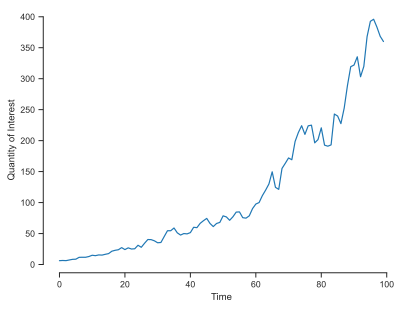

In [20]:
# Define the parameters
key, subkey = jr.split(key)
# Our system needs an initial condition
X_0 = jr.uniform(subkey, (1,), minval=1, maxval=10)
# This constant defines the growth rate, scaling the drift term
mu = 0.05
# This constant defines the noise strength, scaling the diffusion term
std = 0.1
# We define the range of time points we want to simulate
time = jnp.arange(0, 100, 1.0)
# Define the time step for the simulation to take at each iteration
dt = jnp.diff(time, axis=0)

# We package the parameters into a tuple to pass to lax.scan
init_carry = (key, mu, std, X_0)

# We use lax.scan to iterate over the time points
_, X_t = lax.scan(euler_maruyama_step, init_carry, dt)

# We concatenate the initial condition with the results
all_X = jnp.concatenate((X_0, X_t.squeeze()))

# Plot the results
plt.figure()
plt.plot(time, all_X, color=colors[0])
plt.xlabel("Time")
plt.ylabel("Quantity of Interest")
sns.despine(trim=True)
plt.show()

Wow, thats fast! Can you feel the power of lax.scan? 

Feel free to play around with the drift and volatility parameters to see how they affect the growth over time and get a feel for how the model behaves.

Now, we know that when working with computers, multiplication can lead to some numerical instabilities. So what we can do is work in the log-space. This turns our stochastic exponential growth into a simple drift-diffusion process. We can write the log of the population size as:

$$
Y_t = \log(X_t)
$$

As a reminder here is our original SDE:

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

Now as we transform this, something very strange happens because of [Ito's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma). The transformed SDE is:

$$
dY_t = (\mu - \frac{1}{2} \sigma^2) dt + \sigma dW_t
$$

Let me show you.

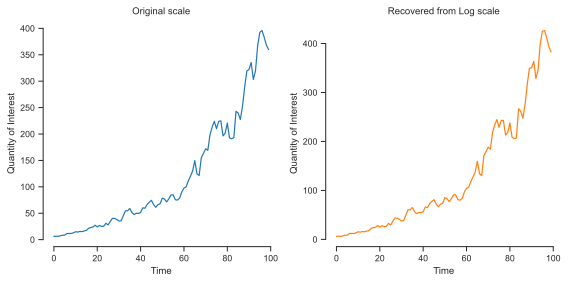

In [21]:
# Define the Euler-Maruyama method on the log scale
def euler_maruyama_step_log(carry, dt):
    """Perform a single step of the Euler-Maruyama method in log-space."""
    # Unpack the state
    key, mu, std, y0 = carry

    # Split the random key for a fresh normal sample each step
    key, subkey = jr.split(key)

    # Compute the drift in log-space
    drift = (mu - 0.5 * std**2) * dt

    # Compute the diffusion term in log-space
    diffusion = std * jnp.sqrt(dt) * jr.normal(subkey)

    # Update Y
    y1 = y0 + drift + diffusion

    return (key, mu, std, y1), y1


Y_0 = jnp.log(X_0)

# See that we are feeding the exact same parameters as before
init_carry_log = (key, mu, std, Y_0)

# We use lax.scan to iterate over the time points
_, Y_t = lax.scan(euler_maruyama_step_log, init_carry_log, dt)

# We concatenate the initial condition with the results
all_Y = jnp.concatenate((Y_0, Y_t.squeeze()))

X_recovered = jnp.exp(all_Y)

# Plot the results side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(time, all_X, color=colors[0])
axs[0].set_title("Original scale")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Quantity of Interest")
axs[1].plot(time, X_recovered, color=colors[1])
axs[1].set_title("Recovered from Log scale")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Quantity of Interest")
sns.despine(trim=True)
plt.tight_layout()
plt.show()


### Fitting the Model to Data

Okay! Armed with this knowledge, lets return to the our dataset. To fit the model to our observed data, we will follow a maximum liklihood approach. We will use the likelihood function to estimate the parameters that maximize the likelihood of observing the data given the model. Note that because we have irregularly spaced data, we will need to keep track of the time intervals between observations.

Starting from the original stochastic exponential growth model:

$$
dX_t = \mu X_t\,dt + \sigma X_t\,dW_t.
$$

Apply the log-transformation:

$$
Y_t = \ln(X_t).
$$

By Itô's lemma:

$$
dY_t = \left(\mu - \tfrac{\sigma^2}{2}\right) dt + \sigma dW_t.
$$

Define $\theta = \mu - \tfrac{\sigma^2}{2}$. The discrete increments in log-space are:

$$
\Delta Y_i = Y_{t_{i+1}} - Y_{t_i} \sim \mathcal{N}(\theta \Delta t_i,\ \sigma^2 \Delta t_i).
$$

The likelihood for the observed increments $\Delta Y_i$ is:

$$
L(\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi \sigma^2 \Delta t_i}}
\exp\left(-\frac{(\Delta Y_i - \theta \Delta t_i)^2}{2\sigma^2 \Delta t_i}\right).
$$

Taking the negative log-likelihood:

$$
\mathcal{L}(\theta,\sigma) = \sum_{i=1}^N \left[\frac{1}{2}\log(2\pi\sigma^2\Delta t_i) 
+ \frac{(\Delta Y_i - \theta \Delta t_i)^2}{2\sigma^2 \Delta t_i}\right].
$$

For parameter estimation, constants like $2\pi$ do not affect the minimizer, so focusing on the terms involving $\theta$ and $\sigma$, we have:

$$
\mathcal{L}(\theta,\sigma) = \sum_{i=1}^N \left[\frac{1}{2}\log(\sigma^2\Delta t_i) 
+ \frac{(\Delta Y_i - \theta \Delta t_i)^2}{2\sigma^2 \Delta t_i}\right].
$$

Now, if our parameters are functions of time or state, here is where we would leave it, but if we choose to parametrize them as constants, we can use the closed-form solution for the maximum likelihood estimates. 

### Estimating $\theta$

Take the derivative with respect to $\theta$:

$$
\frac{\partial \mathcal{L}}{\partial \theta} 
= \sum_{i=1}^N \frac{(\Delta Y_i - \theta \Delta t_i)(- \Delta t_i)}{\sigma^2 \Delta t_i}
= -\frac{1}{\sigma^2} \sum_{i=1}^N(\Delta Y_i - \theta \Delta t_i).
$$

Set equal to zero to find the MLE $\hat{\theta}$:

$$
\sum_{i=1}^N(\Delta Y_i - \hat{\theta}\Delta t_i) = 0 \implies \sum_{i=1}^N \Delta Y_i = \hat{\theta}\sum_{i=1}^N \Delta t_i.
$$

Thus:

$$
\hat{\theta} = \frac{\sum_{i=1}^N \Delta Y_i}{\sum_{i=1}^N \Delta t_i}.
$$

### Estimating $\sigma$

Now differentiate with respect to $\sigma^2$:

$$
\frac{\partial \mathcal{L}}{\partial \sigma^2} 
= \frac{N}{2\sigma^2} - \frac{1}{2(\sigma^2)^2}\sum_{i=1}^N \frac{(\Delta Y_i - \hat{\theta}\Delta t_i)^2}{\Delta t_i}.
$$

Set this equal to zero:

$$
\frac{N}{2\sigma^2} = \frac{1}{2(\sigma^2)^2}\sum_{i=1}^N\frac{(\Delta Y_i - \hat{\theta}\Delta t_i)^2}{\Delta t_i}.
$$

Multiply both sides by $(\sigma^2)^2$:

$$
N\sigma^2 = \sum_{i=1}^N \frac{(\Delta Y_i - \hat{\theta}\Delta t_i)^2}{\Delta t_i}.
$$

Therefore:

$$
\hat{\sigma}^2 = \frac{1}{N} \sum_{i=1}^N \frac{(\Delta Y_i - \hat{\theta}\Delta t_i)^2}{\Delta t_i}.
$$

Recall $\theta = \mu - \frac{\sigma^2}{2}$. Solving for $\mu$:

$$
\hat{\mu} = \hat{\theta} + \frac{\hat{\sigma}^2}{2}.
$$

### MLEs in Log-Space

We have derived:

$$
\hat{\theta} = \frac{\sum_{i=1}^N \Delta Y_i}{\sum_{i=1}^N \Delta t_i}, \quad
\hat{\sigma}^2 = \frac{1}{N}\sum_{i=1}^N \frac{(\Delta Y_i - \hat{\theta}\Delta t_i)^2}{\Delta t_i}, \quad
\hat{\mu} = \hat{\theta} + \frac{\hat{\sigma}^2}{2}.
$$

Thus, by working in log-space, we obtain simple closed-form analytical solutions for $\mu$ and $\sigma$.

### Multiple Replicates Case

If we have $R$ independent replicates of the process, each replicate $r$ for $r=1,\dots,R$ provides a set of increments $\{\Delta Y_i^{(r)}\}_{i=1}^N$ over the same time intervals $\{\Delta t_i\}_{i=1}^N$.

The likelihood contributions from each replicate are independent, so their joint likelihood is the product of individual replicate likelihoods, and the joint log-likelihood is the sum of individual log-likelihoods.

Following the same steps as the single-replicate derivation, but now summing over all replicates, we arrive at the following MLEs:

$$
\hat{\theta} = \frac{\sum_{r=1}^R\sum_{i=1}^N \Delta Y_i^{(r)}}{R \sum_{i=1}^N \Delta t_i},
$$

$$
\hat{\sigma}^2 = \frac{\sum_{r=1}^R\sum_{i=1}^N \frac{(\Delta Y_i^{(r)} - \hat{\theta}\Delta t_i)^2}{\Delta t_i}}{R N},
$$

and as before,

$$
\hat{\mu} = \hat{\theta} + \frac{\hat{\sigma}^2}{2}.
$$

Thus, by pooling information from all $R$ replicates, we again obtain closed-form analytical solutions for $\mu$ and $\sigma$ when working in log-space.



In [22]:
def estimate_params_log(Y, t):
    """
    Estimate mu and sigma for the stochastic exponential growth model in log-space
    given multiple replicates.

    Parameters
    ----------
    Y : jnp.ndarray
        A 2D array of shape (N+1, R), where each column corresponds to log(X_t) values 
        for a single replicate observed at the same time points.
    t : jnp.ndarray
        A 1D array of shape (N+1,) containing the time points t_0, t_1, ..., t_N.

    Returns
    -------
    mu_hat : float
        The MLE estimate of mu.
    sigma_hat : float
        The MLE estimate of sigma.
    """
    # Number of increments (N) and replicates (R)
    N = Y.shape[0] - 1
    R = Y.shape[1]

    # Compute time increments Δt_i
    dt = t[1:] - t[:-1]  # shape (N,)

    # Compute increments in Y
    dY = Y[1:, :] - Y[:-1, :]  # shape (N, R)

    # Sum over all increments and all replicates
    total_dY = jnp.sum(dY)       # sum over i and r
    total_dt = jnp.sum(dt)       # sum over i

    # Estimate theta = mu - sigma^2/2
    theta_hat = total_dY / (R * total_dt)

    # Compute residuals for sigma^2 estimation
    dt_expanded = dt[:, None] # shape (N, 1)
    residuals = dY - theta_hat * dt_expanded
    sigma_sq_hat = jnp.sum((residuals**2) / dt_expanded) / (N * R)
    sigma_hat = jnp.sqrt(sigma_sq_hat)

    # Recover mu
    mu_hat = theta_hat + sigma_sq_hat / 2

    return mu_hat, sigma_hat

We are going to fit our model to just one of the seeding conditions, starting with the 10 cell seeding. We will find our parameters using the first 250 hours of the experiment and then simulate the model for the full 350 hours to see how our model can predict the future.

In [23]:
# Replace all zeroes with a small value to avoid log(0)
P10_no0 = P10.at[P10 == 0].set(1e-6)

# Separate the data into training and testing sets
train_mask = t10 < 250
test_mask = t10 >= 250

train_t10 = t10[train_mask]
train_P10 = P10_no0[train_mask]

test_t10 = t10[test_mask]
test_P10 = P10_no0[test_mask]

# Log-transform the training data
log_trainP10 = jnp.log(train_P10)

# Fit the model to only the training data
mu10_train, sigma10_train = estimate_params_log(jnp.log(train_P10), train_t10)

print(f"The estimated mu for n=10 on the training set is: {mu10_train:.3f}")
print(f"The estimated sigma for n=10 on the training set is: {sigma10_train:.3f}")

The estimated mu for n=10 on the training set is: 0.010
The estimated sigma for n=10 on the training set is: 0.073


Great, now we have the parameters that define our stochastic exponential growth model. We can use these to simulate the model and compare it to the observed data. First, we want to make sure that we are using the correct initial conditions. The data is nominally seeded with 10 cells, but let's go ahead an take a look.

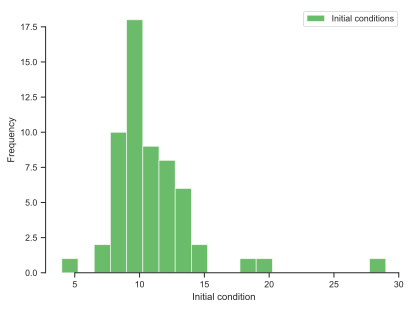

In [24]:
data_IC = P10[0] # Initial condition

# Plot a histogram of the IC
plt.figure()
plt.hist(data_IC, bins=20, color=colors[2], alpha=0.7, label="Initial conditions")
plt.xlabel("Initial condition")
plt.ylabel("Frequency")
plt.legend()
sns.despine(trim=True)
plt.show()

Okay so we see it is seeded with anywhere from 5-30 cells. In the log space we can just construct a normal distribution and sample the initial conditions from that.

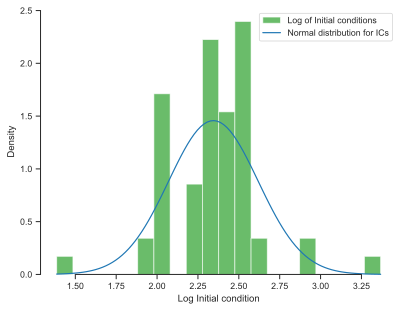

In [25]:
log_IC = jnp.log(data_IC) # Log-transform the initial condition

IC_mean = jnp.mean(log_IC)
IC_std = jnp.std(log_IC)

# Plot a histogram of the log-transformed IC with the normal distribution
plt.figure()
plt.hist(log_IC, bins=20, color=colors[2], alpha=0.7, density=True, label='Log of Initial conditions')
plt.xlabel("Log Initial condition")
plt.ylabel("Density")
x = jnp.linspace(jnp.min(log_IC), jnp.max(log_IC), 100)
y = jss.norm.pdf(x, IC_mean, IC_std)
plt.plot(x, y, color=colors[0], label="Normal distribution for ICs")
plt.legend()
sns.despine(trim=True)
plt.show()

Okay, so we will sample from this distribution to get our initial condition for the simulation. Let's take a look at the simulation and how it performs on the entire time series.

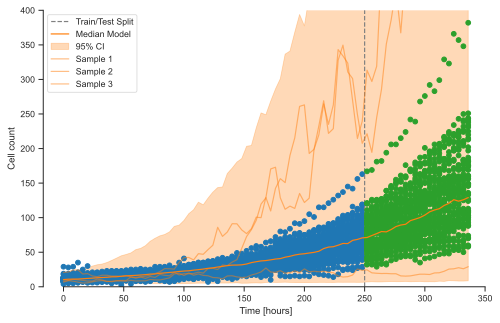

In [26]:
# Create dt for the entire time range (train + test)
dt_full = jnp.diff(t10, axis=0)

# Define the number of samples to draw
n_samples = 1000
sim_keys = jr.split(key, n_samples)

X10_sims = []

for i in range(n_samples):
    key = sim_keys[i]
    key, subkey = jr.split(key)

    # Sample a new initial condition from a normal distribution
    Y0 = jr.normal(subkey) * IC_std + IC_mean

    # Simulate over the entire time range using parameters from the training set
    _, Y_t = lax.scan(euler_maruyama_step_log, (key, mu10_train, sigma10_train, Y0), dt_full)

    # Recover the cell count from the log-transformed data
    all_Y = jnp.concatenate((jnp.array([Y0]), Y_t.squeeze()))
    X10_recovered = jnp.exp(all_Y)
    X10_sims.append(X10_recovered)

# Convert the list of samples to a JAX array
X10_sims = jnp.array(X10_sims).T  # Shape: (N+1, n_samples)

# Compute summary statistics
X10_median = jnp.median(X10_sims, axis=1)
X10_lower = jnp.quantile(X10_sims, 0.025, axis=1)
X10_upper = jnp.quantile(X10_sims, 0.975, axis=1)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_t10, train_P10, 'o', color=colors[0])
ax.axvline(250, color='gray', linestyle='--', label="Train/Test Split")
ax.plot(test_t10, test_P10, 'o', color=colors[2])
ax.plot(t10, X10_median, color=colors[1], label="Median Model")
ax.fill_between(t10, X10_lower, X10_upper, color=colors[1], alpha=0.3, label="95% CI")
# Plot a few samples
for i in range(3):
    ax.plot(t10, X10_sims[:, i], color=colors[1], alpha=0.5, label=f'Sample {i+1}')
ax.set_xlabel("Time [hours]")
ax.set_ylim(0, 400)
ax.set_ylabel("Cell count")
ax.legend()
sns.despine(trim=True)
plt.show()

What can we see from the simulation's prediction? It captures the trend of the data in the median model, but take a look at those samples. We want our model's samples to reflect the qualitative behavior of the data, but here a sample doesn't look like an individual replicate of the data. We will need to add some more complexity to our model to capture the correct behavior of cell growth. These different model formulations is what the Johnson et al. paper is about. They compare different models to see which one best fits the data.